In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, Subset, random_split

import timm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from PIL import Image
from tqdm import tqdm
import pandas as pd
from collections import Counter
import random




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
DATASET_PATH = "/kaggle/input/cotton-leaf-dataset/Augmented Dataset/Augmented Dataset"
MODEL_NAME = "swin_tiny_patch4_window7_224"
IMAGE_SIZE = 224

In [4]:
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4

In [5]:
K_FOLDS = 5
RANDOM_STATE = 42 

In [6]:
class CottonLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for disease_class in self.classes:
            class_dir = os.path.join(root_dir, disease_class)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[disease_class])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
def show_sample_images(root_dir):
    classes = sorted(os.listdir(root_dir))
    fig, axes = plt.subplots(len(classes), 4, figsize=(12, 12))
    fig.suptitle("Sample Images from Each Class", fontsize=16)
    for i, disease_class in enumerate(classes):
        class_dir = os.path.join(root_dir, disease_class)
        img_names = random.sample(os.listdir(class_dir), 4)
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(disease_class, rotation=90, x=-0.1, y=0.5, ha="right")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [8]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Displaying sample images from the dataset...


/tmp/ipykernel_35/1065952778.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


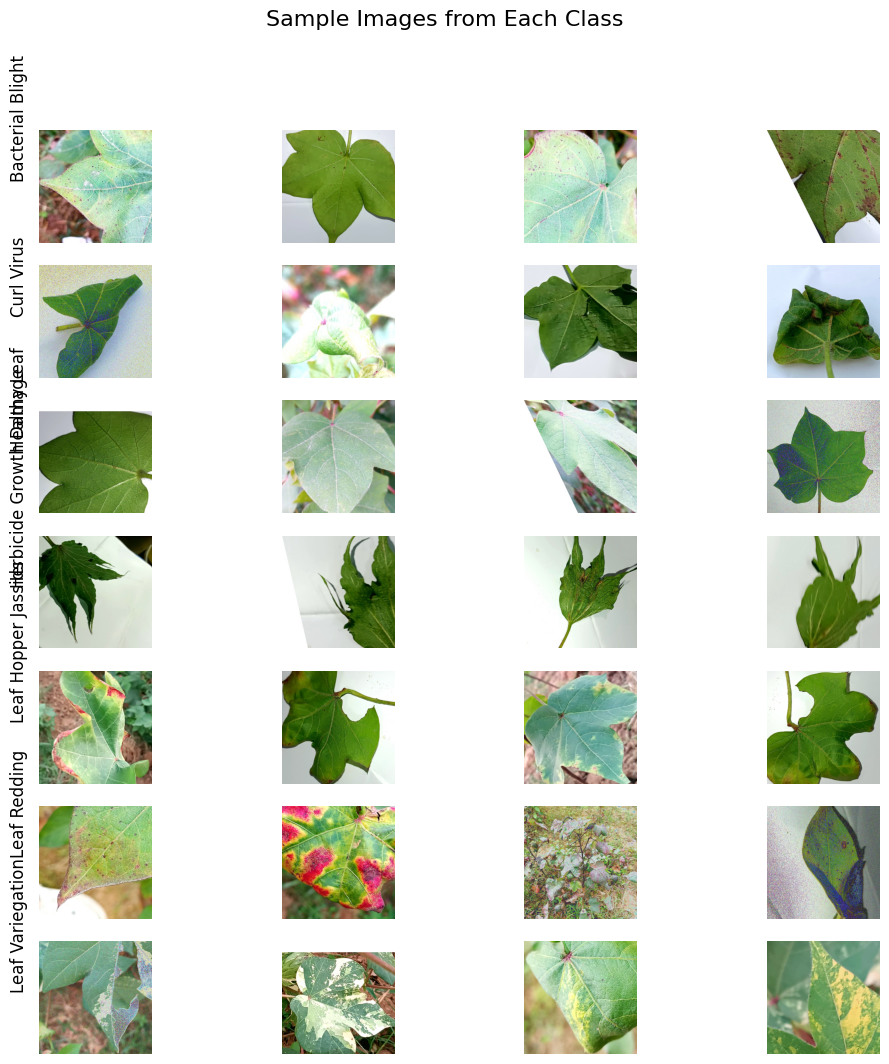

In [9]:
print("Displaying sample images from the dataset...")
show_sample_images(DATASET_PATH)

In [10]:
full_dataset = CottonLeafDataset(DATASET_PATH, transform=transform)

In [11]:
test_ratio = 0.2
test_size = int(len(full_dataset) * test_ratio)
train_val_size = len(full_dataset) - test_size

In [12]:
generator = torch.Generator().manual_seed(RANDOM_STATE)
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size], generator=generator)

In [13]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
print(f"Total images: {len(full_dataset)}")
print(f"Training/Validation set size: {len(train_val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Total images: 7000
Training/Validation set size: 5600
Test set size: 1400


In [15]:
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [16]:
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

In [17]:
fold_accuracies = []

In [18]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print("\n" + "="*50)
    print(f"========== FOLD {fold + 1}/{K_FOLDS} ==========")
    print("="*50)

    # Create subsets for training and validation for the current fold
    train_subset = Subset(train_val_dataset, train_idx)
    val_subset = Subset(train_val_dataset, val_idx)

    # Create DataLoaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize a new model for each fold
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(full_dataset.classes))
    model.to(device)

    # Setup optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    # Store metrics for this specific fold
    fold_train_losses, fold_val_losses = [], []
    fold_train_accs, fold_val_accs = [], []

    # Training loop for the current fold
    for epoch in range(NUM_EPOCHS):
        # --- Training Phase ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Fold {fold+1}, Epoch {epoch+1}/{NUM_EPOCHS} [T]")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        fold_train_losses.append(train_loss)
        fold_train_accs.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        fold_val_losses.append(val_loss)
        fold_val_accs.append(val_acc)

        print(f"Epoch {epoch+1} Summary -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()

    # After the last epoch, save the metrics and the model
    history['train_loss'].append(fold_train_losses)
    history['val_loss'].append(fold_val_losses)
    history['train_acc'].append(fold_train_accs)
    history['val_acc'].append(fold_val_accs)
    fold_accuracies.append(val_acc) # Append the final validation accuracy

    # Save the trained model for this fold
    torch.save(model.state_dict(), f"swin_fold{fold+1}.pth")
    print(f"Saved model for Fold {fold+1} with final validation accuracy: {val_acc:.4f}")


========== FOLD 1/5 ==========


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Fold 1, Epoch 1/20 [T]: 100%|██████████| 140/140 [02:06<00:00,  1.11it/s, acc=0.8710, loss=0.1218]


Epoch 1 Summary -> Train Loss: 0.3789, Train Acc: 0.8710 | Val Loss: 0.1071, Val Acc: 0.9634


Fold 1, Epoch 2/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9603, loss=0.0298]


Epoch 2 Summary -> Train Loss: 0.1176, Train Acc: 0.9603 | Val Loss: 0.1224, Val Acc: 0.9661


Fold 1, Epoch 3/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9701, loss=0.0065]


Epoch 3 Summary -> Train Loss: 0.0974, Train Acc: 0.9701 | Val Loss: 0.1680, Val Acc: 0.9500


Fold 1, Epoch 4/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9828, loss=0.0384]


Epoch 4 Summary -> Train Loss: 0.0552, Train Acc: 0.9828 | Val Loss: 0.0495, Val Acc: 0.9848


Fold 1, Epoch 5/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9679, loss=0.1205]


Epoch 5 Summary -> Train Loss: 0.0987, Train Acc: 0.9679 | Val Loss: 0.1697, Val Acc: 0.9473


Fold 1, Epoch 6/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9786, loss=0.0075]


Epoch 6 Summary -> Train Loss: 0.0686, Train Acc: 0.9786 | Val Loss: 0.0978, Val Acc: 0.9732


Fold 1, Epoch 7/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9891, loss=0.0012]


Epoch 7 Summary -> Train Loss: 0.0342, Train Acc: 0.9891 | Val Loss: 0.0311, Val Acc: 0.9920


Fold 1, Epoch 8/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9949, loss=0.0031]


Epoch 8 Summary -> Train Loss: 0.0163, Train Acc: 0.9949 | Val Loss: 0.0184, Val Acc: 0.9946


Fold 1, Epoch 9/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9973, loss=0.0040]


Epoch 9 Summary -> Train Loss: 0.0086, Train Acc: 0.9973 | Val Loss: 0.0179, Val Acc: 0.9929


Fold 1, Epoch 10/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9951, loss=0.0129]


Epoch 10 Summary -> Train Loss: 0.0144, Train Acc: 0.9951 | Val Loss: 0.0197, Val Acc: 0.9955


Fold 1, Epoch 11/20 [T]: 100%|██████████| 140/140 [01:22<00:00,  1.70it/s, acc=0.9958, loss=0.0155]


Epoch 11 Summary -> Train Loss: 0.0152, Train Acc: 0.9958 | Val Loss: 0.0325, Val Acc: 0.9920


Fold 1, Epoch 12/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9987, loss=0.0069]


Epoch 12 Summary -> Train Loss: 0.0044, Train Acc: 0.9987 | Val Loss: 0.0075, Val Acc: 0.9955


Fold 1, Epoch 13/20 [T]: 100%|██████████| 140/140 [01:22<00:00,  1.70it/s, acc=0.9969, loss=0.0002]


Epoch 13 Summary -> Train Loss: 0.0073, Train Acc: 0.9969 | Val Loss: 0.0134, Val Acc: 0.9946


Fold 1, Epoch 14/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9987, loss=0.0015]


Epoch 14 Summary -> Train Loss: 0.0034, Train Acc: 0.9987 | Val Loss: 0.0107, Val Acc: 0.9946


Fold 1, Epoch 15/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9984, loss=0.0001]


Epoch 15 Summary -> Train Loss: 0.0034, Train Acc: 0.9984 | Val Loss: 0.0071, Val Acc: 0.9973


Fold 1, Epoch 16/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9989, loss=0.0005]


Epoch 16 Summary -> Train Loss: 0.0026, Train Acc: 0.9989 | Val Loss: 0.0100, Val Acc: 0.9964


Fold 1, Epoch 17/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9989, loss=0.0001]


Epoch 17 Summary -> Train Loss: 0.0018, Train Acc: 0.9989 | Val Loss: 0.0110, Val Acc: 0.9964


Fold 1, Epoch 18/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9993, loss=0.0001]


Epoch 18 Summary -> Train Loss: 0.0017, Train Acc: 0.9993 | Val Loss: 0.0115, Val Acc: 0.9955


Fold 1, Epoch 19/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9989, loss=0.0001]


Epoch 19 Summary -> Train Loss: 0.0017, Train Acc: 0.9989 | Val Loss: 0.0110, Val Acc: 0.9955


Fold 1, Epoch 20/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9993, loss=0.0002]


Epoch 20 Summary -> Train Loss: 0.0015, Train Acc: 0.9993 | Val Loss: 0.0110, Val Acc: 0.9955
Saved model for Fold 1 with final validation accuracy: 0.9955

========== FOLD 2/5 ==========


Fold 2, Epoch 1/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.82it/s, acc=0.8763, loss=0.1671]


Epoch 1 Summary -> Train Loss: 0.3532, Train Acc: 0.8763 | Val Loss: 0.1914, Val Acc: 0.9357


Fold 2, Epoch 2/20 [T]: 100%|██████████| 140/140 [01:20<00:00,  1.74it/s, acc=0.9565, loss=0.2631]


Epoch 2 Summary -> Train Loss: 0.1428, Train Acc: 0.9565 | Val Loss: 0.1023, Val Acc: 0.9670


Fold 2, Epoch 3/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9759, loss=0.0112]


Epoch 3 Summary -> Train Loss: 0.0818, Train Acc: 0.9759 | Val Loss: 0.3581, Val Acc: 0.9045


Fold 2, Epoch 4/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9810, loss=0.2457]


Epoch 4 Summary -> Train Loss: 0.0696, Train Acc: 0.9810 | Val Loss: 0.3714, Val Acc: 0.9107


Fold 2, Epoch 5/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9833, loss=0.0304]


Epoch 5 Summary -> Train Loss: 0.0551, Train Acc: 0.9833 | Val Loss: 0.0813, Val Acc: 0.9768


Fold 2, Epoch 6/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9853, loss=0.0561]


Epoch 6 Summary -> Train Loss: 0.0491, Train Acc: 0.9853 | Val Loss: 0.1051, Val Acc: 0.9670


Fold 2, Epoch 7/20 [T]: 100%|██████████| 140/140 [01:20<00:00,  1.74it/s, acc=0.9942, loss=0.0006]


Epoch 7 Summary -> Train Loss: 0.0204, Train Acc: 0.9942 | Val Loss: 0.0753, Val Acc: 0.9804


Fold 2, Epoch 8/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9929, loss=0.0006]


Epoch 8 Summary -> Train Loss: 0.0225, Train Acc: 0.9929 | Val Loss: 0.0959, Val Acc: 0.9804


Fold 2, Epoch 9/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9953, loss=0.0006]


Epoch 9 Summary -> Train Loss: 0.0136, Train Acc: 0.9953 | Val Loss: 0.0972, Val Acc: 0.9750


Fold 2, Epoch 10/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9935, loss=0.0016]


Epoch 10 Summary -> Train Loss: 0.0225, Train Acc: 0.9935 | Val Loss: 0.0988, Val Acc: 0.9812


Fold 2, Epoch 11/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9946, loss=0.0671]


Epoch 11 Summary -> Train Loss: 0.0151, Train Acc: 0.9946 | Val Loss: 0.0618, Val Acc: 0.9857


Fold 2, Epoch 12/20 [T]: 100%|██████████| 140/140 [01:20<00:00,  1.73it/s, acc=0.9949, loss=0.0045]


Epoch 12 Summary -> Train Loss: 0.0187, Train Acc: 0.9949 | Val Loss: 0.1782, Val Acc: 0.9643


Fold 2, Epoch 13/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9971, loss=0.0002]


Epoch 13 Summary -> Train Loss: 0.0056, Train Acc: 0.9971 | Val Loss: 0.0659, Val Acc: 0.9893


Fold 2, Epoch 14/20 [T]: 100%|██████████| 140/140 [01:21<00:00,  1.72it/s, acc=0.9987, loss=0.0001]


Epoch 14 Summary -> Train Loss: 0.0062, Train Acc: 0.9987 | Val Loss: 0.0482, Val Acc: 0.9893


Fold 2, Epoch 15/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9996, loss=0.0001]


Epoch 15 Summary -> Train Loss: 0.0017, Train Acc: 0.9996 | Val Loss: 0.0753, Val Acc: 0.9866


Fold 2, Epoch 16/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9993, loss=0.0001]


Epoch 16 Summary -> Train Loss: 0.0030, Train Acc: 0.9993 | Val Loss: 0.0669, Val Acc: 0.9893


Fold 2, Epoch 17/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=1.0000, loss=0.0001]


Epoch 17 Summary -> Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0675, Val Acc: 0.9902


Fold 2, Epoch 18/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.82it/s, acc=1.0000, loss=0.0002]


Epoch 18 Summary -> Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0670, Val Acc: 0.9902


Fold 2, Epoch 19/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=1.0000, loss=0.0001]


Epoch 19 Summary -> Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0669, Val Acc: 0.9902


Fold 2, Epoch 20/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=1.0000, loss=0.0000]


Epoch 20 Summary -> Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 0.0669, Val Acc: 0.9902
Saved model for Fold 2 with final validation accuracy: 0.9902

========== FOLD 3/5 ==========


Fold 3, Epoch 1/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.8859, loss=0.0744]


Epoch 1 Summary -> Train Loss: 0.3545, Train Acc: 0.8859 | Val Loss: 0.2821, Val Acc: 0.9286


Fold 3, Epoch 2/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.9587, loss=0.0939]


Epoch 2 Summary -> Train Loss: 0.1296, Train Acc: 0.9587 | Val Loss: 0.1490, Val Acc: 0.9482


Fold 3, Epoch 3/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.9763, loss=0.0510]


Epoch 3 Summary -> Train Loss: 0.0771, Train Acc: 0.9763 | Val Loss: 0.1019, Val Acc: 0.9643


Fold 3, Epoch 4/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.9739, loss=0.0986]


Epoch 4 Summary -> Train Loss: 0.1034, Train Acc: 0.9739 | Val Loss: 0.2076, Val Acc: 0.9384


Fold 3, Epoch 5/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.9714, loss=0.0108]


Epoch 5 Summary -> Train Loss: 0.0913, Train Acc: 0.9714 | Val Loss: 0.0612, Val Acc: 0.9741


Fold 3, Epoch 6/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.9848, loss=0.1507]


Epoch 6 Summary -> Train Loss: 0.0463, Train Acc: 0.9848 | Val Loss: 0.0457, Val Acc: 0.9830


Fold 3, Epoch 7/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.83it/s, acc=0.9891, loss=0.0265]


Epoch 7 Summary -> Train Loss: 0.0388, Train Acc: 0.9891 | Val Loss: 0.0844, Val Acc: 0.9723


Fold 3, Epoch 8/20 [T]: 100%|██████████| 140/140 [01:20<00:00,  1.74it/s, acc=0.9926, loss=0.0348]


Epoch 8 Summary -> Train Loss: 0.0212, Train Acc: 0.9926 | Val Loss: 0.0607, Val Acc: 0.9812


Fold 3, Epoch 9/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.84it/s, acc=0.9980, loss=0.0005]


Epoch 9 Summary -> Train Loss: 0.0076, Train Acc: 0.9980 | Val Loss: 0.0440, Val Acc: 0.9848


Fold 3, Epoch 10/20 [T]: 100%|██████████| 140/140 [01:20<00:00,  1.74it/s, acc=0.9951, loss=0.0015]


Epoch 10 Summary -> Train Loss: 0.0156, Train Acc: 0.9951 | Val Loss: 0.0497, Val Acc: 0.9821


Fold 3, Epoch 11/20 [T]: 100%|██████████| 140/140 [01:20<00:00,  1.73it/s, acc=0.9964, loss=0.0003]


Epoch 11 Summary -> Train Loss: 0.0117, Train Acc: 0.9964 | Val Loss: 0.0290, Val Acc: 0.9902


Fold 3, Epoch 12/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9993, loss=0.0014]


Epoch 12 Summary -> Train Loss: 0.0033, Train Acc: 0.9993 | Val Loss: 0.0260, Val Acc: 0.9902


Fold 3, Epoch 13/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9996, loss=0.0005]


Epoch 13 Summary -> Train Loss: 0.0021, Train Acc: 0.9996 | Val Loss: 0.0298, Val Acc: 0.9875


Fold 3, Epoch 14/20 [T]: 100%|██████████| 140/140 [01:21<00:00,  1.73it/s, acc=0.9989, loss=0.0001]


Epoch 14 Summary -> Train Loss: 0.0022, Train Acc: 0.9989 | Val Loss: 0.0234, Val Acc: 0.9902


Fold 3, Epoch 15/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9987, loss=0.0000]


Epoch 15 Summary -> Train Loss: 0.0024, Train Acc: 0.9987 | Val Loss: 0.0188, Val Acc: 0.9929


Fold 3, Epoch 16/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.82it/s, acc=0.9991, loss=0.0000]


Epoch 16 Summary -> Train Loss: 0.0015, Train Acc: 0.9991 | Val Loss: 0.0221, Val Acc: 0.9902


Fold 3, Epoch 17/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9987, loss=0.0001]


Epoch 17 Summary -> Train Loss: 0.0020, Train Acc: 0.9987 | Val Loss: 0.0215, Val Acc: 0.9911


Fold 3, Epoch 18/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9991, loss=0.0000]


Epoch 18 Summary -> Train Loss: 0.0017, Train Acc: 0.9991 | Val Loss: 0.0219, Val Acc: 0.9911


Fold 3, Epoch 19/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9993, loss=0.0000]


Epoch 19 Summary -> Train Loss: 0.0011, Train Acc: 0.9993 | Val Loss: 0.0212, Val Acc: 0.9920


Fold 3, Epoch 20/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.79it/s, acc=0.9996, loss=0.0010]


Epoch 20 Summary -> Train Loss: 0.0011, Train Acc: 0.9996 | Val Loss: 0.0215, Val Acc: 0.9920
Saved model for Fold 3 with final validation accuracy: 0.9920

========== FOLD 4/5 ==========


Fold 4, Epoch 1/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s, acc=0.8933, loss=0.2408]


Epoch 1 Summary -> Train Loss: 0.3306, Train Acc: 0.8933 | Val Loss: 0.3162, Val Acc: 0.9080


Fold 4, Epoch 2/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s, acc=0.9509, loss=0.2762]


Epoch 2 Summary -> Train Loss: 0.1470, Train Acc: 0.9509 | Val Loss: 0.1287, Val Acc: 0.9616


Fold 4, Epoch 3/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9589, loss=0.0401]


Epoch 3 Summary -> Train Loss: 0.1198, Train Acc: 0.9589 | Val Loss: 0.1450, Val Acc: 0.9598


Fold 4, Epoch 4/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s, acc=0.9795, loss=0.0119]


Epoch 4 Summary -> Train Loss: 0.0666, Train Acc: 0.9795 | Val Loss: 0.0820, Val Acc: 0.9768


Fold 4, Epoch 5/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s, acc=0.9871, loss=0.0061]


Epoch 5 Summary -> Train Loss: 0.0478, Train Acc: 0.9871 | Val Loss: 0.0723, Val Acc: 0.9759


Fold 4, Epoch 6/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9817, loss=0.0966]


Epoch 6 Summary -> Train Loss: 0.0672, Train Acc: 0.9817 | Val Loss: 0.0708, Val Acc: 0.9786


Fold 4, Epoch 7/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9924, loss=0.0050]


Epoch 7 Summary -> Train Loss: 0.0266, Train Acc: 0.9924 | Val Loss: 0.0724, Val Acc: 0.9821


Fold 4, Epoch 8/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s, acc=0.9900, loss=0.1771]


Epoch 8 Summary -> Train Loss: 0.0362, Train Acc: 0.9900 | Val Loss: 0.1502, Val Acc: 0.9607


Fold 4, Epoch 9/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9886, loss=0.0015]


Epoch 9 Summary -> Train Loss: 0.0353, Train Acc: 0.9886 | Val Loss: 0.0528, Val Acc: 0.9920


Fold 4, Epoch 10/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9996, loss=0.0006]


Epoch 10 Summary -> Train Loss: 0.0037, Train Acc: 0.9996 | Val Loss: 0.0617, Val Acc: 0.9866


Fold 4, Epoch 11/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9980, loss=0.0004]


Epoch 11 Summary -> Train Loss: 0.0104, Train Acc: 0.9980 | Val Loss: 0.0576, Val Acc: 0.9866


Fold 4, Epoch 12/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9984, loss=0.0035]


Epoch 12 Summary -> Train Loss: 0.0058, Train Acc: 0.9984 | Val Loss: 0.0559, Val Acc: 0.9857


Fold 4, Epoch 13/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9991, loss=0.0002]


Epoch 13 Summary -> Train Loss: 0.0039, Train Acc: 0.9991 | Val Loss: 0.0540, Val Acc: 0.9893


Fold 4, Epoch 14/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9996, loss=0.0001]


Epoch 14 Summary -> Train Loss: 0.0021, Train Acc: 0.9996 | Val Loss: 0.0582, Val Acc: 0.9893


Fold 4, Epoch 15/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9998, loss=0.0001]


Epoch 15 Summary -> Train Loss: 0.0014, Train Acc: 0.9998 | Val Loss: 0.0608, Val Acc: 0.9893


Fold 4, Epoch 16/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9991, loss=0.0003]


Epoch 16 Summary -> Train Loss: 0.0032, Train Acc: 0.9991 | Val Loss: 0.0534, Val Acc: 0.9884


Fold 4, Epoch 17/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9996, loss=0.0002]


Epoch 17 Summary -> Train Loss: 0.0013, Train Acc: 0.9996 | Val Loss: 0.0558, Val Acc: 0.9884


Fold 4, Epoch 18/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9993, loss=0.0001]


Epoch 18 Summary -> Train Loss: 0.0014, Train Acc: 0.9993 | Val Loss: 0.0565, Val Acc: 0.9884


Fold 4, Epoch 19/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9998, loss=0.0005]


Epoch 19 Summary -> Train Loss: 0.0009, Train Acc: 0.9998 | Val Loss: 0.0570, Val Acc: 0.9884


Fold 4, Epoch 20/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9996, loss=0.0003]


Epoch 20 Summary -> Train Loss: 0.0011, Train Acc: 0.9996 | Val Loss: 0.0568, Val Acc: 0.9884
Saved model for Fold 4 with final validation accuracy: 0.9884

========== FOLD 5/5 ==========


Fold 5, Epoch 1/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.8712, loss=0.1434]


Epoch 1 Summary -> Train Loss: 0.3811, Train Acc: 0.8712 | Val Loss: 0.1263, Val Acc: 0.9625


Fold 5, Epoch 2/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9540, loss=0.4322]


Epoch 2 Summary -> Train Loss: 0.1599, Train Acc: 0.9540 | Val Loss: 0.1934, Val Acc: 0.9411


Fold 5, Epoch 3/20 [T]: 100%|██████████| 140/140 [01:16<00:00,  1.82it/s, acc=0.9750, loss=0.0597]


Epoch 3 Summary -> Train Loss: 0.0763, Train Acc: 0.9750 | Val Loss: 0.0633, Val Acc: 0.9777


Fold 5, Epoch 4/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9786, loss=0.0092]


Epoch 4 Summary -> Train Loss: 0.0648, Train Acc: 0.9786 | Val Loss: 0.0522, Val Acc: 0.9795


Fold 5, Epoch 5/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9725, loss=0.0100]


Epoch 5 Summary -> Train Loss: 0.0874, Train Acc: 0.9725 | Val Loss: 0.1353, Val Acc: 0.9625


Fold 5, Epoch 6/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9853, loss=0.0429]


Epoch 6 Summary -> Train Loss: 0.0485, Train Acc: 0.9853 | Val Loss: 0.0636, Val Acc: 0.9857


Fold 5, Epoch 7/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9917, loss=0.0221]


Epoch 7 Summary -> Train Loss: 0.0270, Train Acc: 0.9917 | Val Loss: 0.0723, Val Acc: 0.9839


Fold 5, Epoch 8/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s, acc=0.9960, loss=0.0020]


Epoch 8 Summary -> Train Loss: 0.0127, Train Acc: 0.9960 | Val Loss: 0.0688, Val Acc: 0.9875


Fold 5, Epoch 9/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9971, loss=0.0010]


Epoch 9 Summary -> Train Loss: 0.0078, Train Acc: 0.9971 | Val Loss: 0.0590, Val Acc: 0.9866


Fold 5, Epoch 10/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.81it/s, acc=0.9984, loss=0.0000]


Epoch 10 Summary -> Train Loss: 0.0071, Train Acc: 0.9984 | Val Loss: 0.0386, Val Acc: 0.9920


Fold 5, Epoch 11/20 [T]: 100%|██████████| 140/140 [01:17<00:00,  1.80it/s, acc=0.9987, loss=0.0001]


Epoch 11 Summary -> Train Loss: 0.0043, Train Acc: 0.9987 | Val Loss: 0.0560, Val Acc: 0.9902


Fold 5, Epoch 12/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9978, loss=0.0000]


Epoch 12 Summary -> Train Loss: 0.0054, Train Acc: 0.9978 | Val Loss: 0.0355, Val Acc: 0.9929


Fold 5, Epoch 13/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9989, loss=0.0001]


Epoch 13 Summary -> Train Loss: 0.0018, Train Acc: 0.9989 | Val Loss: 0.0312, Val Acc: 0.9929


Fold 5, Epoch 14/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9989, loss=0.0003]


Epoch 14 Summary -> Train Loss: 0.0023, Train Acc: 0.9989 | Val Loss: 0.0370, Val Acc: 0.9929


Fold 5, Epoch 15/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9987, loss=0.0000]


Epoch 15 Summary -> Train Loss: 0.0029, Train Acc: 0.9987 | Val Loss: 0.0508, Val Acc: 0.9920


Fold 5, Epoch 16/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.79it/s, acc=0.9984, loss=0.0001]


Epoch 16 Summary -> Train Loss: 0.0026, Train Acc: 0.9984 | Val Loss: 0.0488, Val Acc: 0.9929


Fold 5, Epoch 17/20 [T]: 100%|██████████| 140/140 [01:18<00:00,  1.78it/s, acc=0.9993, loss=0.0000]


Epoch 17 Summary -> Train Loss: 0.0017, Train Acc: 0.9993 | Val Loss: 0.0453, Val Acc: 0.9929


Fold 5, Epoch 18/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.76it/s, acc=0.9993, loss=0.0001]


Epoch 18 Summary -> Train Loss: 0.0015, Train Acc: 0.9993 | Val Loss: 0.0450, Val Acc: 0.9929


Fold 5, Epoch 19/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9993, loss=0.0002]


Epoch 19 Summary -> Train Loss: 0.0015, Train Acc: 0.9993 | Val Loss: 0.0452, Val Acc: 0.9929


Fold 5, Epoch 20/20 [T]: 100%|██████████| 140/140 [01:19<00:00,  1.77it/s, acc=0.9993, loss=0.0000]


Epoch 20 Summary -> Train Loss: 0.0013, Train Acc: 0.9993 | Val Loss: 0.0453, Val Acc: 0.9929
Saved model for Fold 5 with final validation accuracy: 0.9929


In [48]:
print("\n" + "="*50)
print("K-FOLD CROSS-VALIDATION ANALYSIS")
print("="*50)

fold_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(K_FOLDS)],
    'Final Validation Accuracy': fold_accuracies
})

mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
summary_row = pd.DataFrame({'Fold': ['Mean'], 'Final Validation Accuracy': [mean_acc]})
std_row = pd.DataFrame({'Fold': ['Std Dev'], 'Final Validation Accuracy': [std_acc]})
fold_results = pd.concat([fold_results, summary_row, std_row], ignore_index=True)

print("K-Fold Performance Summary:")
print(fold_results.to_string(index=False))
print(f"\nAverage Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


K-FOLD CROSS-VALIDATION ANALYSIS
K-Fold Performance Summary:
   Fold  Final Validation Accuracy
 Fold 1                   0.995536
 Fold 2                   0.990179
 Fold 3                   0.991964
 Fold 4                   0.988393
 Fold 5                   0.992857
   Mean                   0.991786
Std Dev                   0.002422

Average Validation Accuracy: 0.9918 ± 0.0024


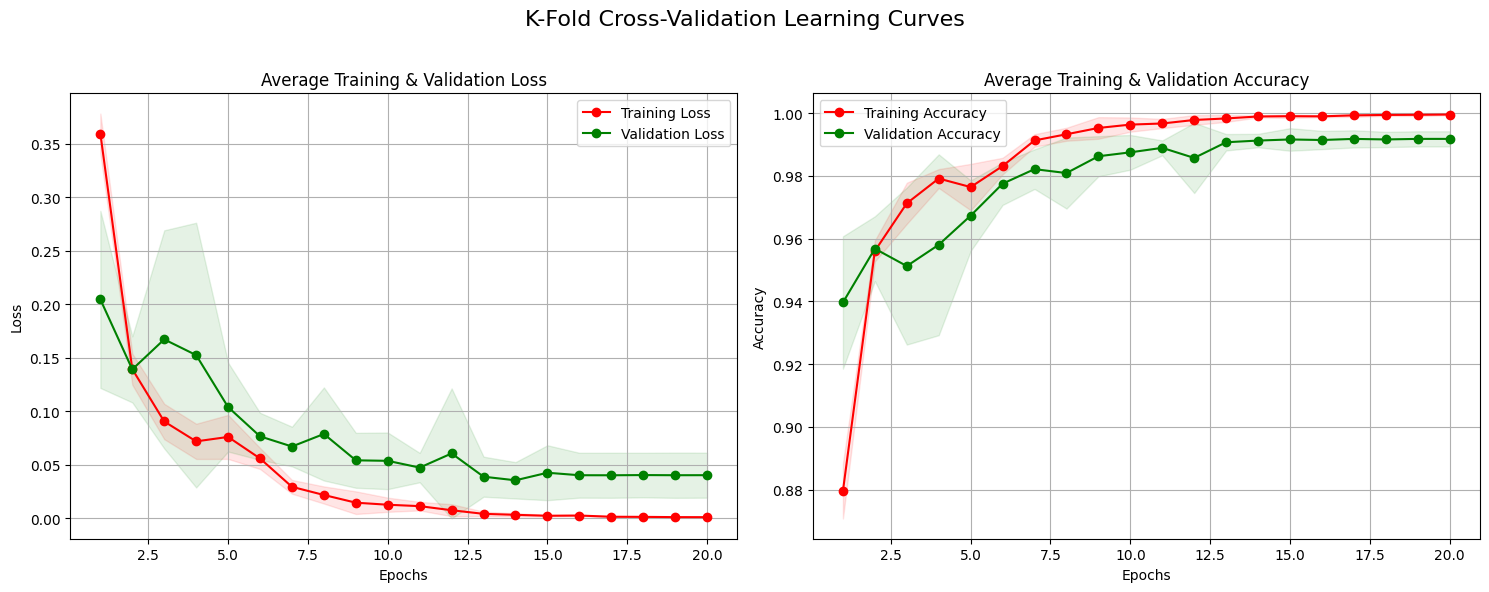

In [50]:
mean_train_loss = np.mean(history['train_loss'], axis=0)
std_train_loss = np.std(history['train_loss'], axis=0)
mean_val_loss = np.mean(history['val_loss'], axis=0)
std_val_loss = np.std(history['val_loss'], axis=0)

mean_train_acc = np.mean(history['train_acc'], axis=0)
std_train_acc = np.std(history['train_acc'], axis=0)
mean_val_acc = np.mean(history['val_acc'], axis=0)
std_val_acc = np.std(history['val_acc'], axis=0)

epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mean_train_loss, 'o-', color="r", label="Training Loss")
plt.fill_between(epochs_range, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.1, color="r")
plt.plot(epochs_range, mean_val_loss, 'o-', color="g", label="Validation Loss")
plt.fill_between(epochs_range, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.1, color="g")
plt.title("Average Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mean_train_acc, 'o-', color="r", label="Training Accuracy")
plt.fill_between(epochs_range, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, alpha=0.1, color="r")
plt.plot(epochs_range, mean_val_acc, 'o-', color="g", label="Validation Accuracy")
plt.fill_between(epochs_range, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.1, color="g")
plt.title("Average Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.suptitle("K-Fold Cross-Validation Learning Curves", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [51]:
print("\n" + "="*50)
print("FINAL MODEL EVALUATION ON THE HELD-OUT TEST SET")
print("="*50)

best_fold_idx = np.argmax(fold_accuracies)
best_model_path = f"swin_fold{best_fold_idx + 1}.pth"
print(f"Loading best model from Fold {best_fold_idx + 1}, with validation accuracy: {fold_accuracies[best_fold_idx]:.4f}")


FINAL MODEL EVALUATION ON THE HELD-OUT TEST SET
Loading best model from Fold 1, with validation accuracy: 0.9955


In [52]:
best_model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=len(full_dataset.classes))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [53]:
true_labels = []
predicted_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        # Get probabilities for ROC curve
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

Evaluating on Test Set: 100%|██████████| 44/44 [00:18<00:00,  2.36it/s]


In [54]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
all_probs = np.array(all_probs)
class_names = full_dataset.classes

In [55]:
test_accuracy = np.mean(true_labels == predicted_labels)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")


Test Set Accuracy: 0.9936


In [56]:
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       1.00      0.99      0.99       207
             Curl Virus       1.00      0.98      0.99       215
           Healthy Leaf       0.98      1.00      0.99       198
Herbicide Growth Damage       1.00      1.00      1.00       197
    Leaf Hopper Jassids       0.99      0.99      0.99       198
           Leaf Redding       0.98      0.99      0.99       189
       Leaf Variegation       1.00      1.00      1.00       196

               accuracy                           0.99      1400
              macro avg       0.99      0.99      0.99      1400
           weighted avg       0.99      0.99      0.99      1400



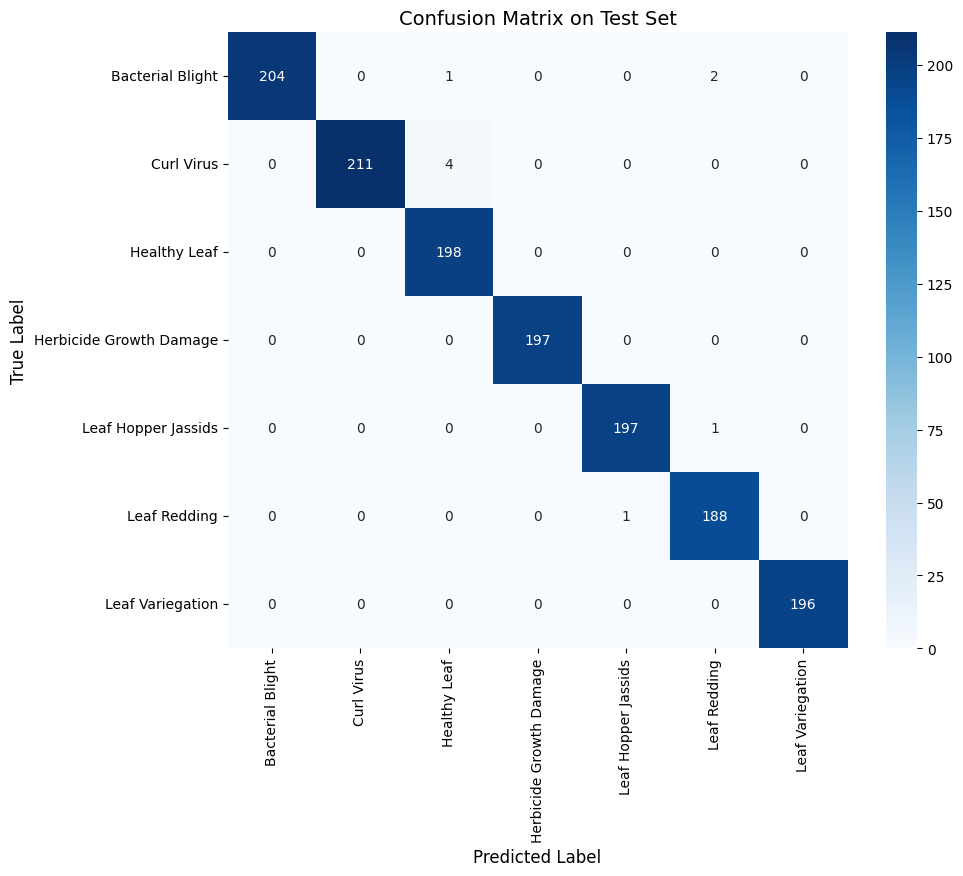

In [57]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.show()

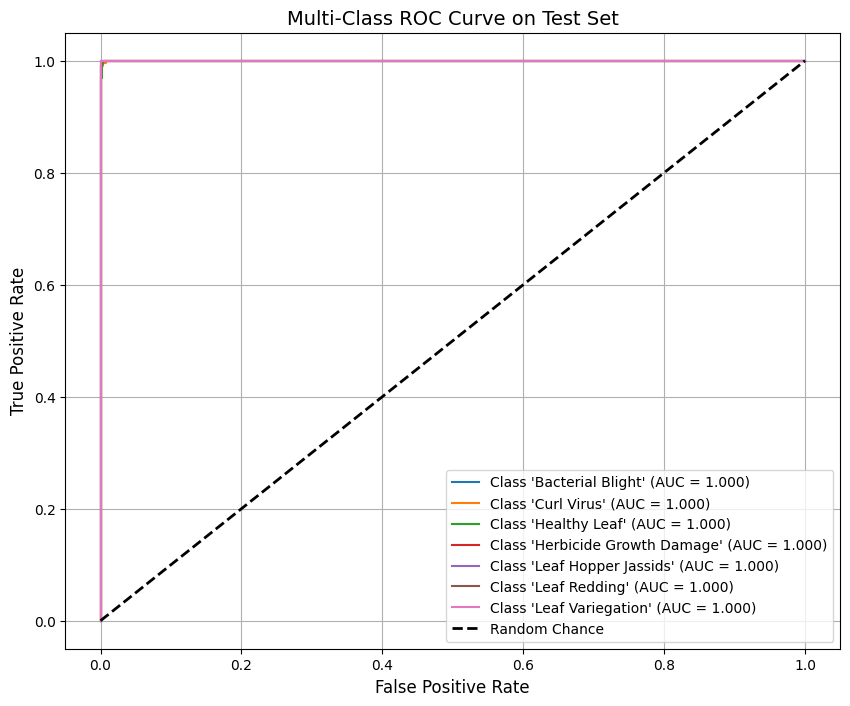

In [58]:
true_binarized = label_binarize(true_labels, classes=range(len(class_names)))
n_classes = true_binarized.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class '{class_names[i]}' (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label="Random Chance")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC Curve on Test Set", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Displaying correctly classified samples...


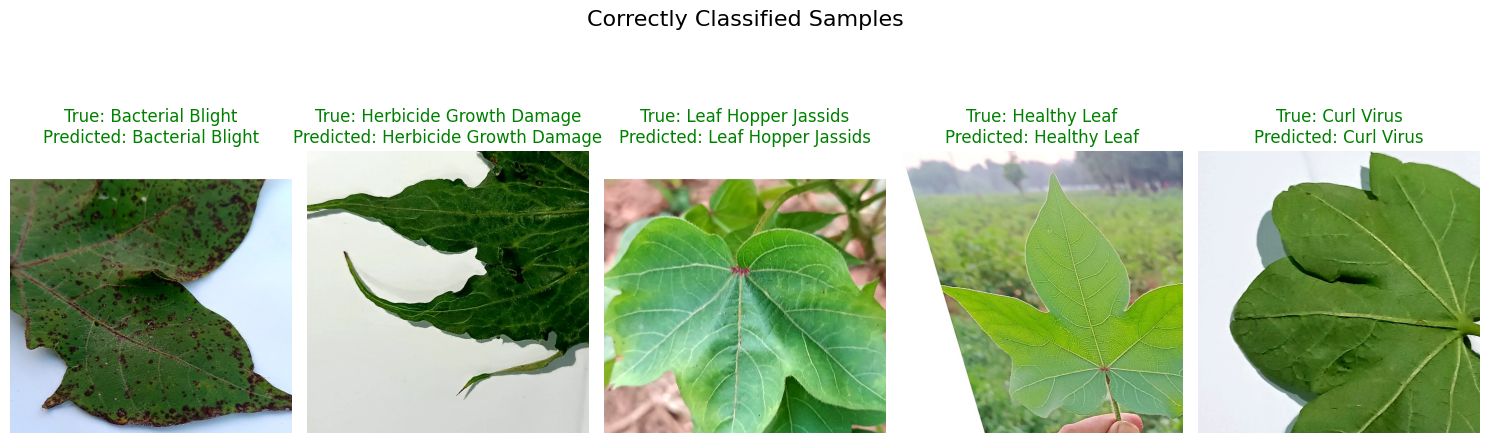


Displaying misclassified samples...


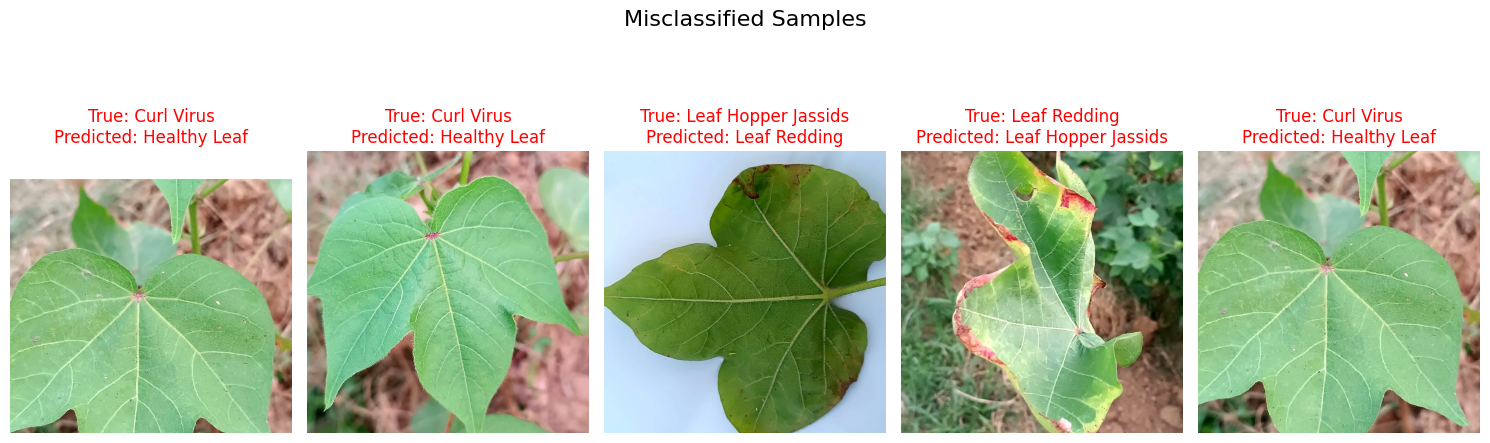

In [59]:
def show_classified_misclassified(n_samples=5):
    correct_indices = np.where(predicted_labels == true_labels)[0]
    misclassified_indices = np.where(predicted_labels != true_labels)[0]
    
    # Get random samples of correct and misclassified images
    correct_samples = random.sample(list(correct_indices), min(n_samples, len(correct_indices)))
    misclassified_samples = random.sample(list(misclassified_indices), min(n_samples, len(misclassified_indices)))
    
    def plot_samples(indices, title):
        fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
        fig.suptitle(title, fontsize=16)
        for i, idx in enumerate(indices):
            # Get the original image path from the full dataset using the test_dataset's index mapping
            original_idx = test_dataset.indices[idx]
            img_path = full_dataset.image_paths[original_idx]
            image = Image.open(img_path)
            
            true_class = class_names[true_labels[idx]]
            pred_class = class_names[predicted_labels[idx]]
            
            axes[i].imshow(image)
            axes[i].set_title(f"True: {true_class}\nPredicted: {pred_class}", 
                              color="green" if true_class == pred_class else "red")
            axes[i].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.90])
        plt.show()

    print("\nDisplaying correctly classified samples...")
    plot_samples(correct_samples, "Correctly Classified Samples")
    
    if len(misclassified_samples) > 0:
        print("\nDisplaying misclassified samples...")
        plot_samples(misclassified_samples, "Misclassified Samples")
    else:
        print("\nNo misclassified samples found in the test set!")

show_classified_misclassified(n_samples=5)


MODEL INTERPRETABILITY WITH GRAD-CAM (Final Corrected Version)
Loading a fresh, clean model instance to be safe...
Clean model loaded. Now generating visualizations...


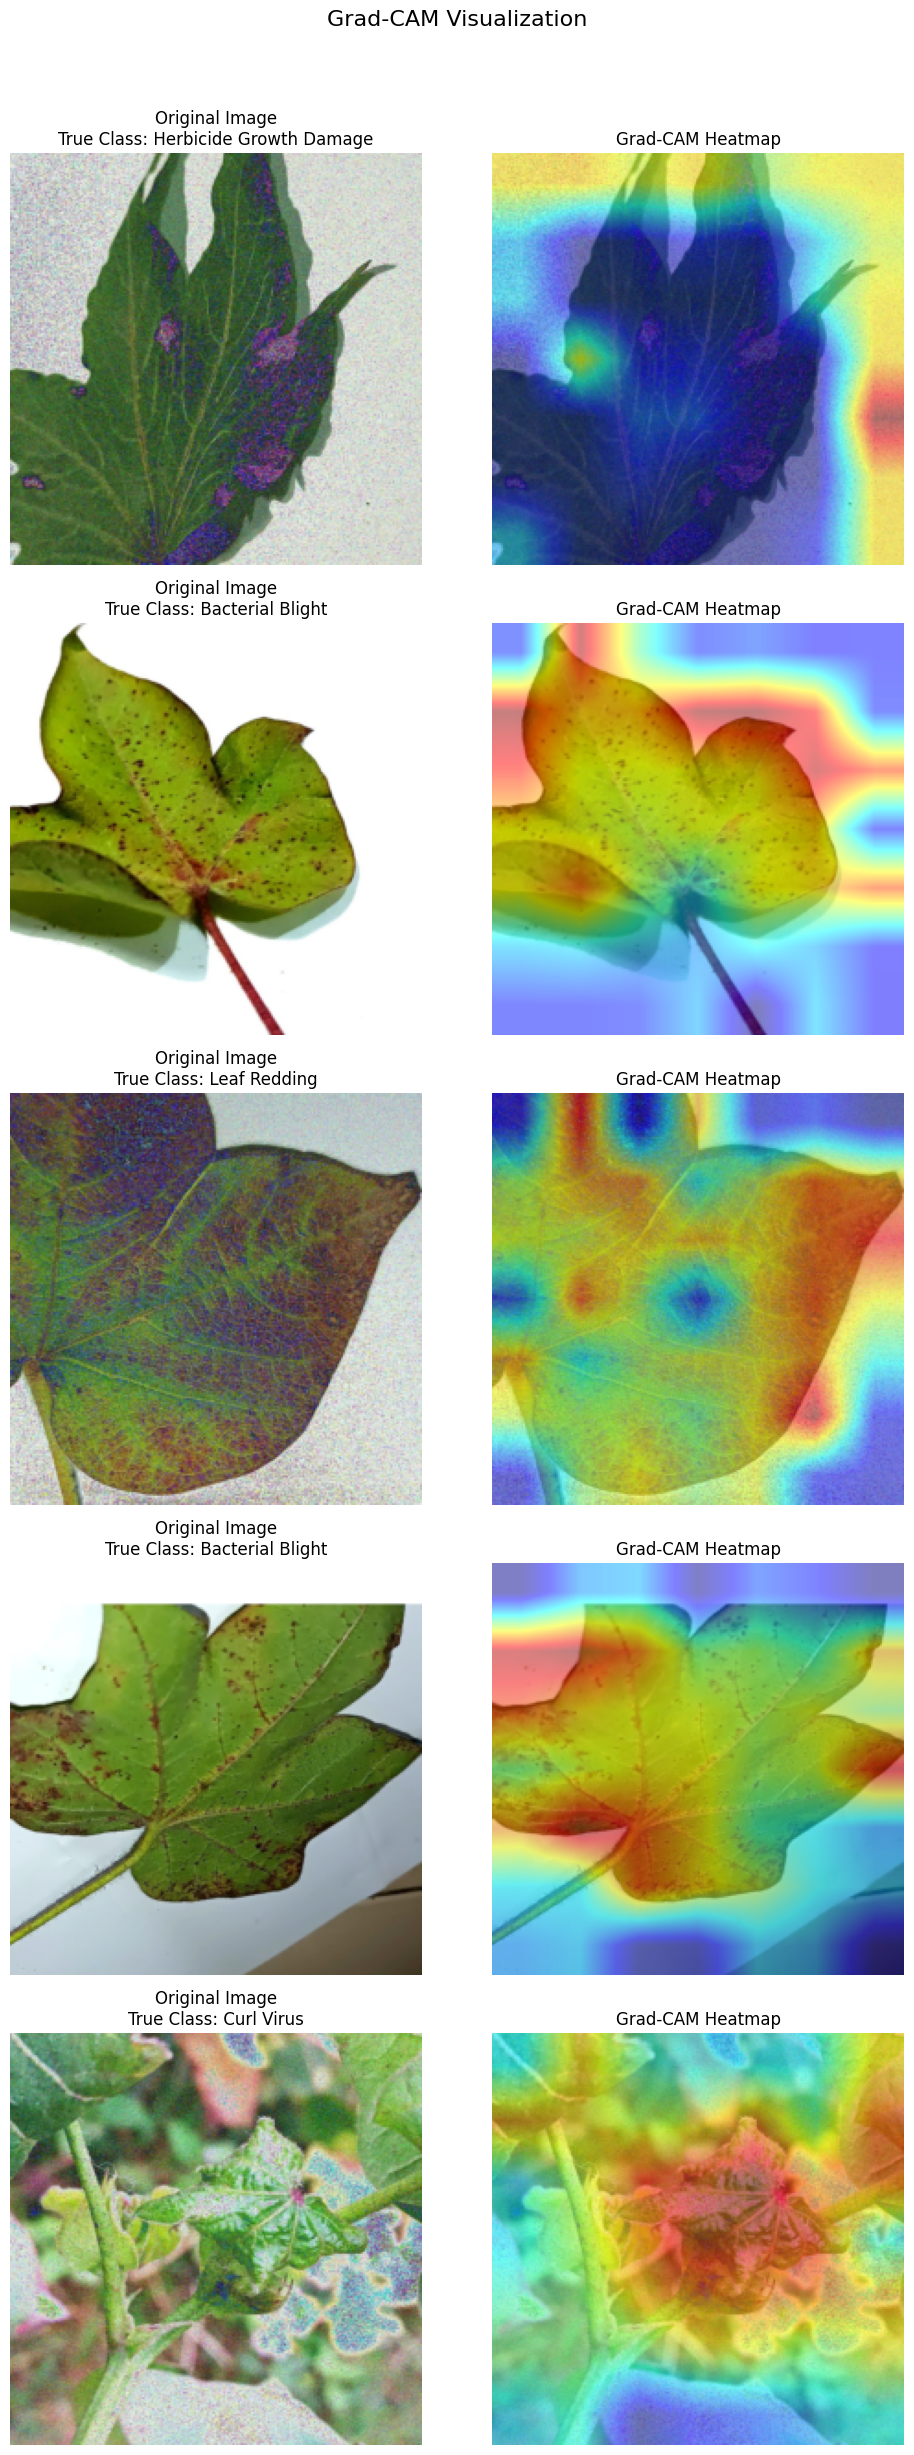

In [116]:

print("\n" + "="*50)
print("MODEL INTERPRETABILITY WITH GRAD-CAM (Final Corrected Version)")
print("="*50)


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def reshape_transform(tensor):
    return tensor.permute(0, 3, 1, 2)


target_layers = [best_model.layers[-1].blocks[-1].norm1]

cam = GradCAM(
    model=best_model,
    target_layers=target_layers,
    reshape_transform=reshape_transform  # This is the crucial addition
)


def visualize_grad_cam(n_images=5):

    random_indices = random.sample(range(len(test_dataset)), n_images)
    

    inv_normalize = transforms.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
    if n_images == 1: axes = np.array([axes]) # Ensure axes is always a list for indexing
    fig.suptitle("Grad-CAM Visualization", fontsize=16)
    
    for i, idx in enumerate(random_indices):
        # Get image tensor and label
        img_tensor, label = test_dataset[idx]
        
        # Grad-CAM requires a batch dimension
        input_tensor = img_tensor.unsqueeze(0)
        
        # Define the target for Grad-CAM
        targets = [ClassifierOutputTarget(label)]
        
        # Generate the CAM. The cam object now knows how to handle the Swin model.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :] # Get the first CAM in the batch
        
        # Get the original image for visualization
        rgb_img = inv_normalize(img_tensor).permute(1, 2, 0).cpu().numpy()
        rgb_img = np.clip(rgb_img, 0, 1)

        # Create the beautiful, smooth, blended visualization
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Plot Original Image
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f"Original Image\nTrue Class: {class_names[label]}")
        axes[i, 0].axis('off')

        # Plot Grad-CAM
        axes[i, 1].imshow(visualization)
        axes[i, 1].set_title("Grad-CAM Heatmap")
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


print("Loading a fresh, clean model instance to be safe...")
best_fold_idx = np.argmax(fold_accuracies)
best_model_path = f"swin_fold{best_fold_idx + 1}.pth"
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.to(device)
best_model.eval()
print("Clean model loaded. Now generating visualizations...")

visualize_grad_cam()